In [218]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import geopandas as gpd
import plotly.express as px
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon
from statsmodels.tsa.api import Holt
from pandas.plotting import register_matplotlib_converters


#### Project Objectives:

 - Analyze the superstore dataset and identify metrics that can be tracked to predict sales for the upcoming fiscal year.
 - Identify product lines that could be expanded. 
 - Provide documentation, notes, and takeaways supporting decisions made in relation to this analysis.
 - Create python scripts containg formulas used to assist with this analysis. 
 - Upload all work related to this analysis to Github and include steps on how to reproduce this exercise.
 
### Acquisition & Preparation

In [219]:
df = pd.read_csv('superstore.csv')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [221]:
# only postal code is missing any values
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

In [222]:
def lower_underscore(string):
    '''
    This function takes in the name of each column in a dataset, lowercases the column name,
    removes blank spaces and replaces those blank spaces with the underscore sign.
    '''
    return string.lower().replace(' ', '_')

df.rename(columns = lower_underscore, inplace = True)

In [223]:
df[df.postal_code.isnull() == True]

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub-category,product_name,sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


In [224]:
df[df['state'] == 'Vermont']

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub-category,product_name,sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,NaN,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,NaN,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04
9148,9149,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,NaN,East,OFF-ST-10001526,Office Supplies,Storage,Iceberg Mobile Mega Data/Printer Cart,1564.29
9386,9387,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10000157,Office Supplies,Paper,Xerox 191,79.92
9387,9388,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-PA-10001970,Office Supplies,Paper,Xerox 1881,12.28
9388,9389,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-AP-10000828,Office Supplies,Appliances,Avanti 4.4 Cu. Ft. Refrigerator,542.94
9389,9390,US-2018-127292,19/01/2018,23/01/2018,Standard Class,RM-19375,Raymond Messe,Consumer,United States,Burlington,Vermont,NaN,East,OFF-EN-10001509,Office Supplies,Envelopes,Poly String Tie Envelopes,2.04


In [225]:
# it looks like the only missing postal code values are for the city of Burlington in Vermont
# After looking up a list of zip codes on google, we can infer the zip code missing is 05401

df.postal_code.fillna(value = 05401.00, inplace = True)
df[df['state'] == 'Vermont'].head()

,row_id,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,country,city,state,postal_code,region,product_id,category,sub-category,product_name,sales
2234,2235,CA-2018-104066,05/12/2018,10/12/2018,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,Vermont,5401.0,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.03
5274,5275,CA-2016-162887,07/11/2016,09/11/2016,Second Class,SV-20785,Stewart Visinsky,Consumer,United States,Burlington,Vermont,5401.0,East,FUR-CH-10000595,Furniture,Chairs,Safco Contoured Stacking Chairs,715.20
8798,8799,US-2017-150140,06/04/2017,10/04/2017,Standard Class,VM-21685,Valerie Mitchum,Home Office,United States,Burlington,Vermont,5401.0,East,TEC-PH-10002555,Technology,Phones,Nortel Meridian M5316 Digital phone,1294.75
9146,9147,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,5401.0,East,TEC-AC-10002926,Technology,Accessories,Logitech Wireless Marathon Mouse M705,99.98
9147,9148,US-2017-165505,23/01/2017,27/01/2017,Standard Class,CB-12535,Claudia Bergmann,Corporate,United States,Burlington,Vermont,5401.0,East,OFF-AR-10003477,Office Supplies,Art,4009 Highlighters,8.04


In [226]:
# let's rename the columns so it's easier to work them during the analysis

cols = list(df.columns)
for i in range(len(cols)):
    cols[i] = cols[i].lower().replace(' ', '_')
cols

['row_id',
 'order_id',
 'order_date',
 'ship_date',
 'ship_mode',
 'customer_id',
 'customer_name',
 'segment',
 'country',
 'city',
 'state',
 'postal_code',
 'region',
 'product_id',
 'category',
 'sub-category',
 'product_name',
 'sales']

In [227]:
# let's go ahead and take care of the '-' in the 'sub-category' feature
df.rename(columns = {'sub-category':'subcategory'}, inplace = True)

In [228]:
# let's order the dataset by date
df.sort_values(by = 'order_date', inplace = True, ascending = True)

In [229]:
# let's convert the date columns into date data types.
df[['order_date', 'ship_date']].value_counts()

order_date  ship_date 
27/12/2016  31/12/2016    18
11/12/2017  11/12/2017    17
02/09/2018  06/09/2018    17
05/09/2017  07/09/2017    16
10/11/2017  14/11/2017    16
                          ..
05/06/2018  06/06/2018     1
            09/06/2018     1
19/02/2018  23/02/2018     1
            21/02/2018     1
01/01/2018  02/01/2018     1
Length: 3427, dtype: int64

In [230]:
df.order_date = pd.to_datetime(df.order_date)
df.ship_date = pd.to_datetime(df.ship_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 4009 to 6341
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   row_id         9800 non-null   int64         
 1   order_id       9800 non-null   object        
 2   order_date     9800 non-null   datetime64[ns]
 3   ship_date      9800 non-null   datetime64[ns]
 4   ship_mode      9800 non-null   object        
 5   customer_id    9800 non-null   object        
 6   customer_name  9800 non-null   object        
 7   segment        9800 non-null   object        
 8   country        9800 non-null   object        
 9   city           9800 non-null   object        
 10  state          9800 non-null   object        
 11  postal_code    9800 non-null   float64       
 12  region         9800 non-null   object        
 13  product_id     9800 non-null   object        
 14  category       9800 non-null   object        
 15  subcategory    980

In [231]:
# let's analyze any rows we can drop
# to drop:
# 1. row_id - can use order_id as 'primary key'
# 2. country - no other country with the exception of US. Can infer country based on columns. 
# df.drop(columns = ('row_id', 'country'), inplace = True)
df.columns


Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'subcategory',
       'product_name', 'sales'],
      dtype='object')

In [232]:
df.row_id
# doesn't look very useful. This column counts from 1 to 9800, the same number of rows in
# this dataset.

4009    4010
6682    6683
8069    8070
8070    8071
8071    8072
        ... 
1153    1154
2821    2822
1152    1153
5738    5739
6341    6342
Name: row_id, Length: 9800, dtype: int64

In [233]:
# can skip order_id through segment as these are self explanatory and will not be dropped
df.segment.value_counts()

Consumer       5101
Corporate      2953
Home Office    1746
Name: segment, dtype: int64

In [234]:
df.country.value_counts()

United States    9800
Name: country, dtype: int64

In [235]:
df.drop(columns = ['row_id', 'country'], inplace = True)

In [236]:
df.city.value_counts()

New York City    891
Los Angeles      728
Philadelphia     532
San Francisco    500
Seattle          426
                ... 
Chapel Hill        1
Orland Park        1
Margate            1
Tinley Park        1
Missoula           1
Name: city, Length: 529, dtype: int64

In [237]:
df.state.nunique()

49

In [238]:
df.region.value_counts()

West       3140
East       2785
Central    2277
South      1598
Name: region, dtype: int64

In [239]:
df.category.value_counts()

Office Supplies    5909
Furniture          2078
Technology         1813
Name: category, dtype: int64

In [240]:
df.subcategory.value_counts()

Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: subcategory, dtype: int64

In [241]:
df.product_name

4009    Howard Miller 11-1/2" Diameter Brentwood Wall ...
6682              Wilson Jones Easy Flow II Sheet Lifters
8069                        SAFCO Boltless Steel Shelving
8070    Tenex Carpeted, Granite-Look or Clear Contempo...
8071         Office Star - Contemporary Task Swivel Chair
                              ...                        
1153                          Lock-Up Easel 'Spel-Binder'
2821                                     Adtran 1202752G1
1152                     Crayola Anti Dust Chalk, 12/Pack
5738    GBC Pre-Punched Binding Paper, Plastic, White,...
6341                          Tennsco Industrial Shelving
Name: product_name, Length: 9800, dtype: object

In [242]:
df.sales.describe()

count     9800.000000
mean       230.769059
std        626.651875
min          0.444000
25%         17.248000
50%         54.490000
75%        210.605000
max      22638.480000
Name: sales, dtype: float64

In [243]:
# setting index to order date
df.set_index('order_date')
df[df.index == '2016-02-29']

,order_id,order_date,ship_date,ship_mode,customer_id,customer_name,segment,city,state,postal_code,region,product_id,category,subcategory,product_name,sales


### Takeaways:

 - close to 10K rows
 - time span of data is from BoY 2015 to EoY 2018
 - dropped a couple of rows:
     - row_id: this column listed the number of each row.
     - country: this column lists the country where a customer is, in this case all clients are.
 - row names renamed to make them easier to work with
 - converted a couple of rows into datetime data types
 - missing values came from the postal code column
     - all values missing were from Burlington, Vermont. Figured out the appropriate zip code by looking it up on google.
 - no leaps day to remove

In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 4009 to 6341
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       9800 non-null   object        
 1   order_date     9800 non-null   datetime64[ns]
 2   ship_date      9800 non-null   datetime64[ns]
 3   ship_mode      9800 non-null   object        
 4   customer_id    9800 non-null   object        
 5   customer_name  9800 non-null   object        
 6   segment        9800 non-null   object        
 7   city           9800 non-null   object        
 8   state          9800 non-null   object        
 9   postal_code    9800 non-null   float64       
 10  region         9800 non-null   object        
 11  product_id     9800 non-null   object        
 12  category       9800 non-null   object        
 13  subcategory    9800 non-null   object        
 14  product_name   9800 non-null   object        
 15  sales          980

### Exploration
- Initial Questions:
 1. What are the most popular/profitable product lines?
 2. What are the sales cycles like and how do they differ between each segment?
 3. What regions/states generate the most sales?
 4. What is the proportion of each clientele segments and what do they buy the most?

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 540 to 1297
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       9800 non-null   object        
 1   order_date     9800 non-null   datetime64[ns]
 2   ship_date      9800 non-null   datetime64[ns]
 3   ship_mode      9800 non-null   object        
 4   customer_id    9800 non-null   object        
 5   customer_name  9800 non-null   object        
 6   segment        9800 non-null   object        
 7   city           9800 non-null   object        
 8   state          9800 non-null   object        
 9   postal_code    9800 non-null   float64       
 10  region         9800 non-null   object        
 11  product_id     9800 non-null   object        
 12  category       9800 non-null   object        
 13  subcategory    9800 non-null   object        
 14  product_name   9800 non-null   object        
 15  sales          9800

In [29]:
objs = df[['ship_mode', 'segment', 'state', 'region', 'category', 'subcategory']]
objs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 540 to 1297
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ship_mode    9800 non-null   object
 1   segment      9800 non-null   object
 2   state        9800 non-null   object
 3   region       9800 non-null   object
 4   category     9800 non-null   object
 5   subcategory  9800 non-null   object
dtypes: object(6)
memory usage: 535.9+ KB


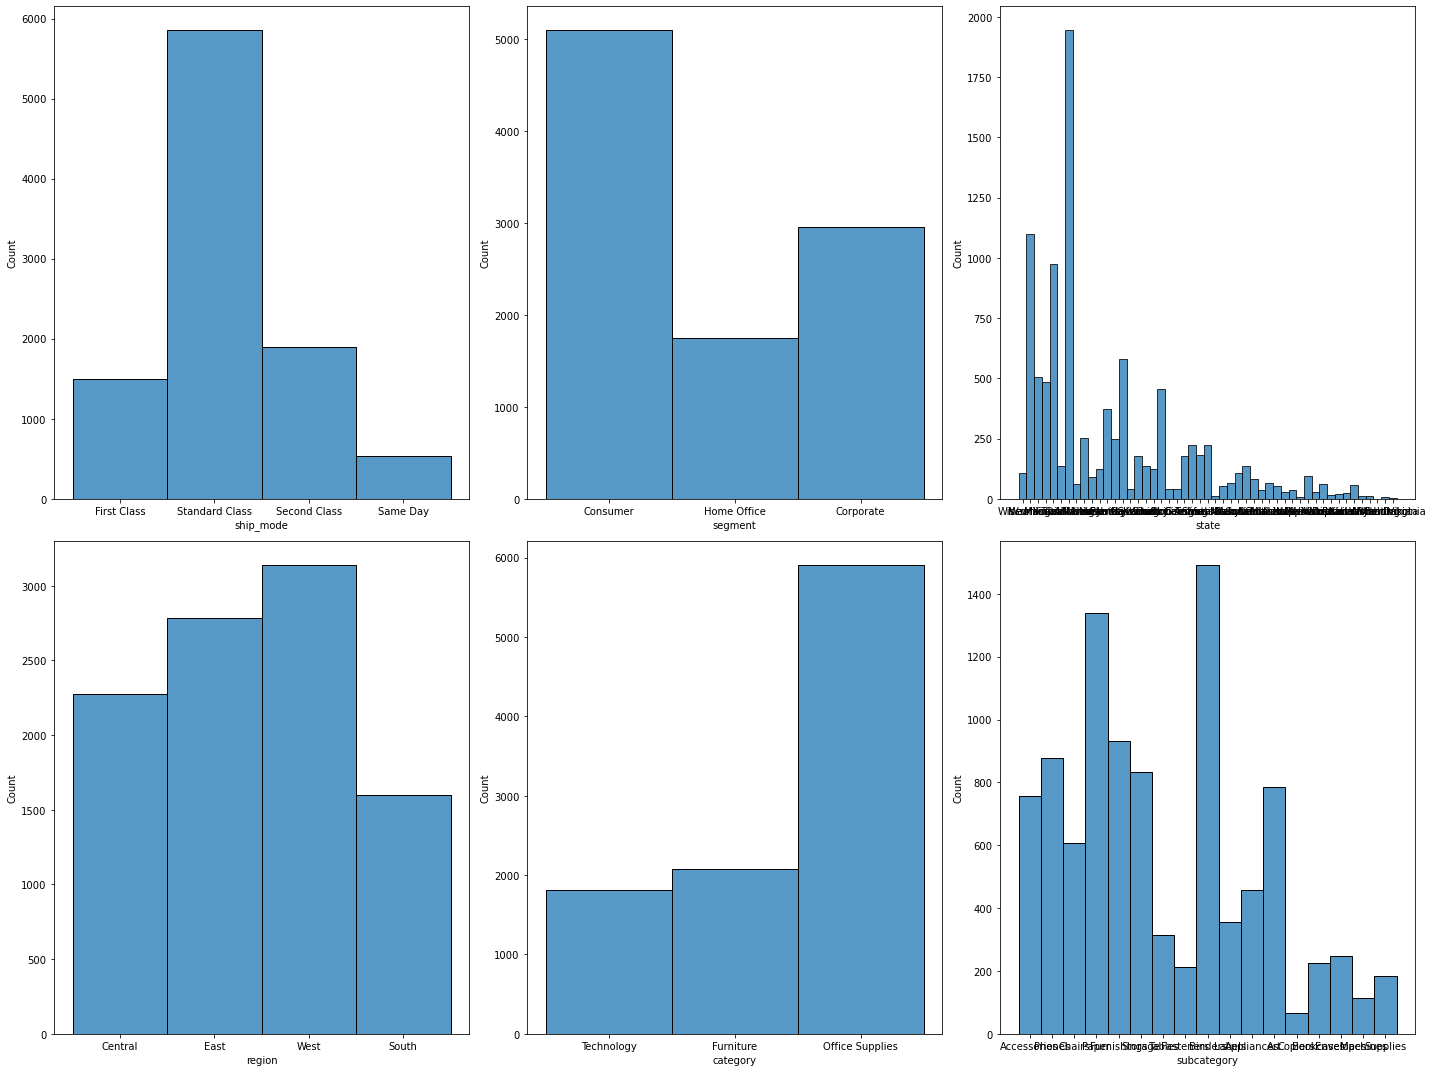

In [30]:
fig, axs = plt.subplots(2, 3, figsize = (20, 15))
fl_ax = axs.ravel()

for i, col in enumerate(objs.columns):
    sns.histplot(x = objs[col], ax = fl_ax[i], ec = 'black')
    plt.tight_layout()    

<AxesSubplot:ylabel='Frequency'>

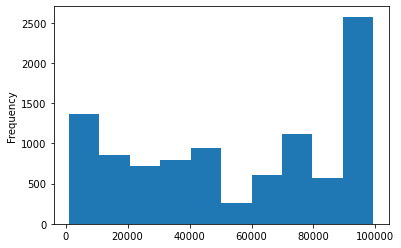

In [31]:
df.postal_code.plot(kind = 'hist')

<AxesSubplot:xlabel='order_date'>

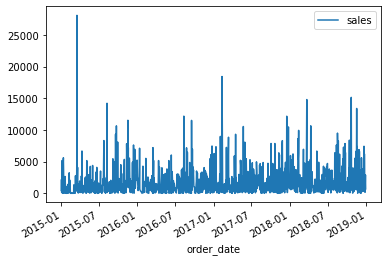

In [32]:
sales_over_time = df.groupby(['order_date']).sales.sum().reset_index()
sales_over_time.plot(x = 'order_date', y = 'sales')

In [33]:
df.sales.describe()

count     9800.000000
mean       230.769059
std        626.651875
min          0.444000
25%         17.248000
50%         54.490000
75%        210.605000
max      22638.480000
Name: sales, dtype: float64

#### 1. What are the most popular/profitable product lines?

In [34]:
df.category.value_counts(normalize = True)

Office Supplies    0.602959
Furniture          0.212041
Technology         0.185000
Name: category, dtype: float64

In [35]:
office_supplies = df[df['category'] == 'Office Supplies'].set_index('order_date')
office_supplies.subcategory.value_counts()

Binders       1492
Paper         1338
Storage        832
Art            785
Appliances     459
Labels         357
Envelopes      248
Fasteners      214
Supplies       184
Name: subcategory, dtype: int64

In [36]:
office_supplies.subcategory.value_counts(normalize = True)

Binders       0.252496
Paper         0.226434
Storage       0.140802
Art           0.132848
Appliances    0.077678
Labels        0.060416
Envelopes     0.041970
Fasteners     0.036216
Supplies      0.031139
Name: subcategory, dtype: float64

In [37]:
furniture = df[df['category'] == 'Furniture'].set_index('order_date')
furniture.subcategory.value_counts()

Furnishings    931
Chairs         607
Tables         314
Bookcases      226
Name: subcategory, dtype: int64

In [38]:
furniture.subcategory.value_counts(normalize = True)

Furnishings    0.448027
Chairs         0.292108
Tables         0.151107
Bookcases      0.108758
Name: subcategory, dtype: float64

In [39]:
technology = df[df['category'] == 'Technology'].set_index('order_date')
technology.subcategory.value_counts()

Phones         876
Accessories    756
Machines       115
Copiers         66
Name: subcategory, dtype: int64

In [40]:
technology.subcategory.value_counts(normalize = True)

Phones         0.483177
Accessories    0.416988
Machines       0.063431
Copiers        0.036404
Name: subcategory, dtype: float64

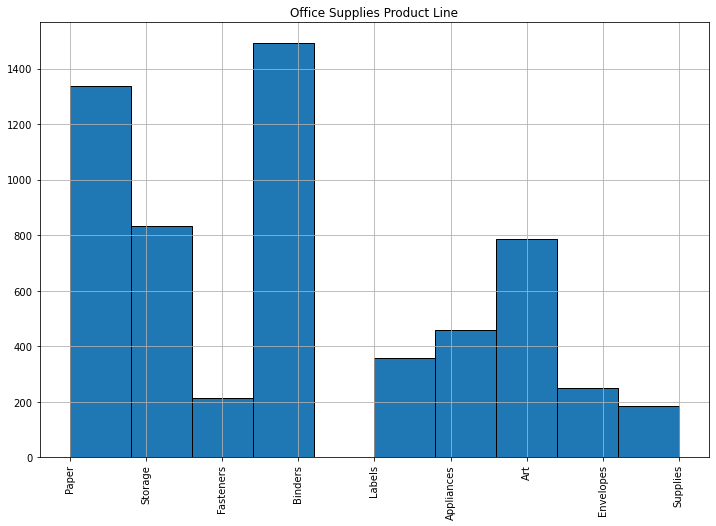

In [41]:
office_supplies.subcategory.hist(figsize = (12, 8), ec = 'black')
plt.title('Office Supplies Product Line')
plt.xticks(rotation = 90);

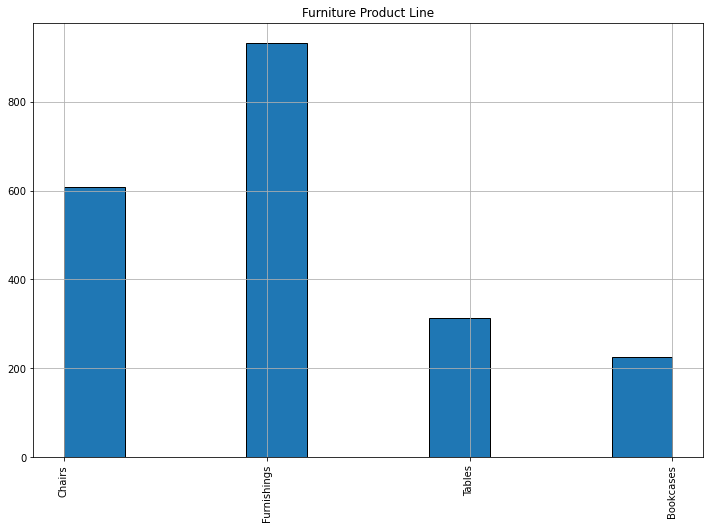

In [42]:
furniture.subcategory.hist(figsize = (12, 8), ec = 'black')
plt.title('Furniture Product Line')
plt.xticks(rotation = 90);

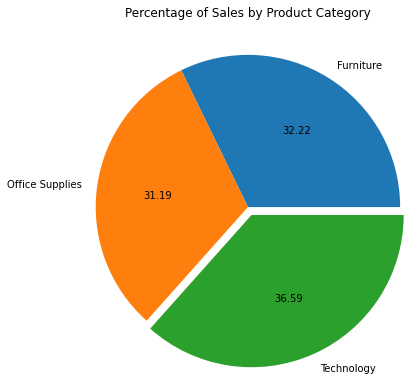

In [43]:
plt.pie(df.groupby('category').sales.sum(),
       autopct = '%.2f',
       labels = list(df.category.sort_values().unique()),
       explode = [0, 0, .1],
       radius = 1.75)
plt.title('Percentage of Sales by Product Category', y = 1.35);

In [44]:
office_supplies.groupby('subcategory').sales.sum()

subcategory
Appliances    104618.403
Art            26705.410
Binders       200028.785
Envelopes      16128.046
Fasteners       3001.960
Labels         12347.726
Paper          76828.304
Storage       219343.392
Supplies       46420.308
Name: sales, dtype: float64

''

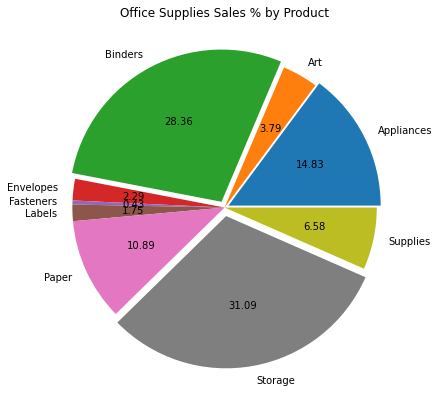

In [45]:
plt.pie(office_supplies.groupby('subcategory').sales.sum(), 
        autopct = '%.2f', 
        labels = list(office_supplies.subcategory.sort_values().unique()), 
        explode = (0.05, 0, 0.075, 0, 0, 0, 0, 0.1, 0),
        radius = 1.75)
plt.title('Office Supplies Sales % by Product', y = 1.35)
;

In [46]:
furniture.groupby('subcategory').sales.sum()

subcategory
Bookcases      113813.1987
Chairs         322822.7310
Furnishings     89212.0180
Tables         202810.6280
Name: sales, dtype: float64

''

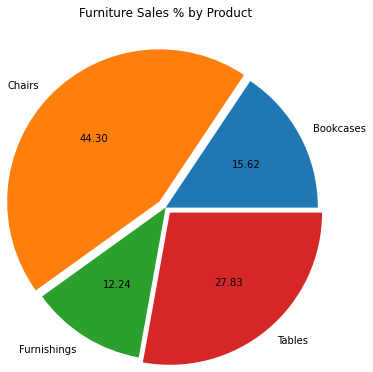

In [47]:
plt.pie(furniture.groupby('subcategory').sales.sum(), 
        autopct = '%.2f', 
        labels = list(furniture.subcategory.sort_values().unique()), 
        explode = (0, .1, 0, .075),
        radius = 1.75)
plt.title('Furniture Sales % by Product', y = 1.35)
;

In [48]:
technology.groupby('subcategory').sales.sum()

subcategory
Accessories    164186.700
Copiers        146248.094
Machines       189238.631
Phones         327782.448
Name: sales, dtype: float64

''

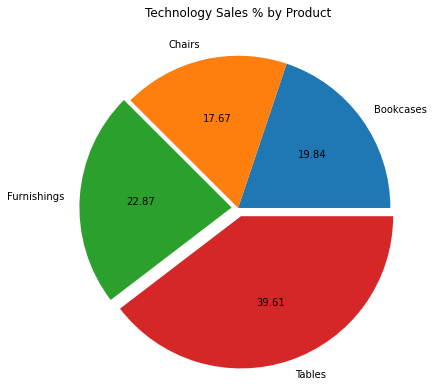

In [49]:
plt.pie(technology.groupby('subcategory').sales.sum(), 
        autopct = '%.2f', 
        labels = list(furniture.subcategory.sort_values().unique()), 
        explode = (0, 0, 0.075, .1),
        radius = 1.75)
plt.title('Technology Sales % by Product', y = 1.35)
;

#### Takeaways:
 - Most popular product category is office supplies with a bit over 60% followed by furniture and technology
 - top three products in each category:
     - office supplies: binders, paper, storage
     - furniture: furnishings, chairs, tables
     - technology: phones, accessories, machines
 - Category sales split:
     - Technology leads with 36.59%
     - Furniture is second with 32.22
     - Office Supplies is third with 31.19
 - Products with highest sales by category:
     - OS: storage - 219K, binders - 200K, and appliances - 105K
     - F: chairs - 322K, tables - 203K, bookcases - 114K
     - T: phones - 328K, machines - 189K, accesories: 164K

#### 2. What are the sales cycles like and how do they differ between each segment?

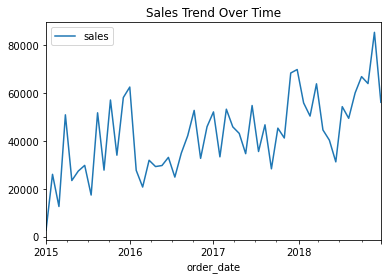

In [50]:
sales_over_time = df.set_index('order_date')
sales_over_time.resample('4W').sum().plot(y = 'sales')
plt.title('Sales Trend Over Time');

In [51]:
sales_over_time.groupby(sales_over_time.index.year).sum().drop(columns = ('postal_code'))

,sales
order_date,
2015,479856.2081
2016,459436.0054
2017,600192.5500
2018,722052.0192


In [52]:
sales_over_time.sales.sum()

2261536.7827000003

In [53]:
sales_over_time.groupby(sales_over_time.index.month).sum().drop(columns = ('postal_code'))

,sales
order_date,
1,155990.9154
2,131153.2594
3,212256.1344
4,142984.2481
5,166000.7467
6,142034.7713
7,159472.5865
8,207601.7939
9,245155.0671


In [54]:
# let's visualize sales by year in a bar chart and also incorporate average sales and 
# include a visualization by month

sales_by_year = sales_over_time.groupby(sales_over_time.index.year).sum()
sales_by_year.drop(columns = ('postal_code'), inplace = True)
sales_by_year.rename(columns = {'sales':'total_sales'}, inplace = True)
sales_by_year['average_sales'] = sales_over_time.groupby(sales_over_time.index.year).sales.mean()

sales_by_month = sales_over_time.groupby(sales_over_time.index.month).sum()
sales_by_month.drop(columns = ('postal_code'), inplace = True)
sales_by_month.rename(columns = {'sales':'total_sales'}, inplace = True)
sales_by_month['average_sales'] = sales_over_time.groupby(sales_over_time.index.month).sales.mean()

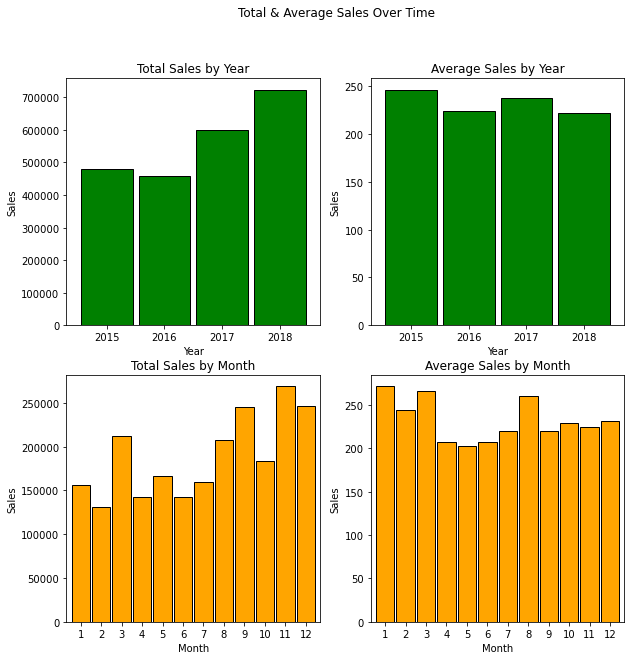

In [55]:
plt.figure(figsize = (10, 10))
plt.suptitle('Total & Average Sales Over Time')

plt.subplot(221)
ax = sales_by_year.total_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Total Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(222)
ax = sales_by_year.average_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Average Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(223)
ax = sales_by_month.total_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Total Sales by Month', xlabel = 'Month', ylabel = 'Sales')

plt.subplot(224)
ax = sales_by_month.average_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Average Sales by Month', xlabel = 'Month', ylabel = 'Sales');

In [56]:
y1 = office_supplies.sales
y2 = furniture.sales
y3 = technology.sales

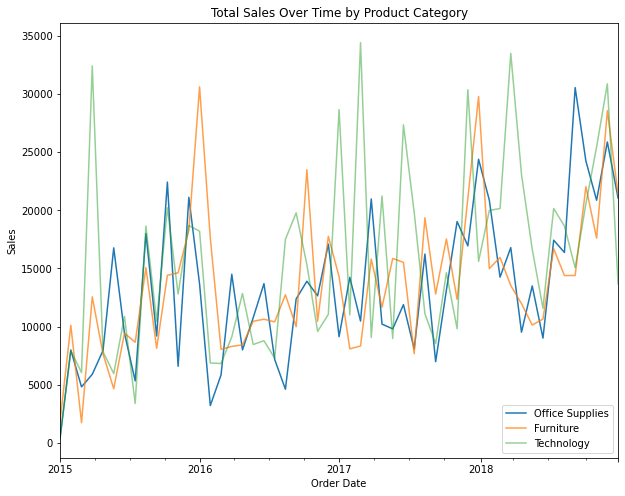

In [57]:
plt.figure(figsize = (10, 8))
y1.resample('4W').sum().plot(alpha = 1, label = 'Office Supplies')
y2.resample('4W').sum().plot(alpha = .75, label = 'Furniture')
y3.resample('4W').sum().plot(alpha = .5, label = 'Technology')
plt.title('Total Sales Over Time by Product Category')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend();

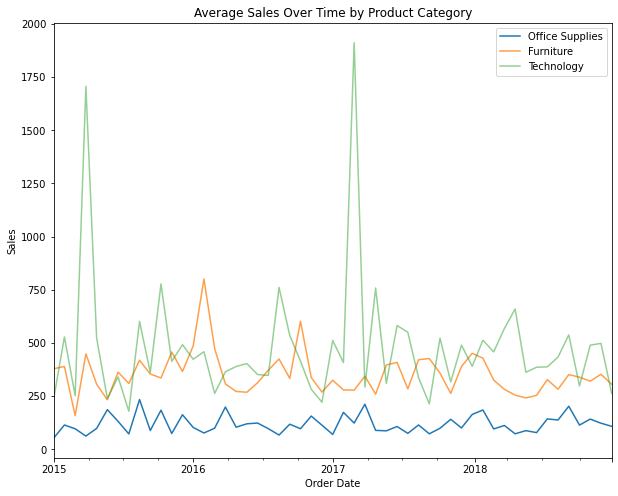

In [58]:
plt.figure(figsize = (10, 8))
y1.resample('4W').mean().plot(alpha = 1, label = 'Office Supplies')
y2.resample('4W').mean().plot(alpha = .75, label = 'Furniture')
y3.resample('4W').mean().plot(alpha = .5, label = 'Technology')
plt.title('Average Sales Over Time by Product Category')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.legend();

In [59]:
office_supplies_by_year = office_supplies.groupby(office_supplies.index.year).sum()
office_supplies_by_year.rename(columns = {'sales':'total_sales'}, inplace = True)
office_supplies_by_year['average_sales'] = office_supplies.groupby(office_supplies.index.year).sales.mean()
furniture_by_year = furniture.groupby(furniture.index.year).sum()
furniture_by_year.rename(columns = {'sales':'total_sales'}, inplace = True)
furniture_by_year['average_sales'] = furniture.groupby(furniture.index.year).sales.mean()
technology_by_year = technology.groupby(technology.index.year).sum()
technology_by_year.rename(columns = {'sales':'total_sales'}, inplace = True)
technology_by_year['average_sales'] = technology.groupby(technology.index.year).sales.mean()

office_supplies_by_month = office_supplies.groupby(office_supplies.index.month).sum()
office_supplies_by_month.rename(columns = {'sales':'total_sales'}, inplace = True)
office_supplies_by_month['average_sales'] = office_supplies.groupby(office_supplies.index.month).sales.mean() 
furniture_by_month = furniture.groupby(furniture.index.month).sum()
furniture_by_month.rename(columns = {'sales':'total_sales'}, inplace = True)
furniture_by_month['average_sales'] = furniture.groupby(furniture.index.month).sales.mean() 
technology_by_month = technology.groupby(technology.index.month).sum()
technology_by_month.rename(columns = {'sales':'total_sales'}, inplace = True)
technology_by_month['average_sales'] = technology.groupby(technology.index.month).sales.mean() 


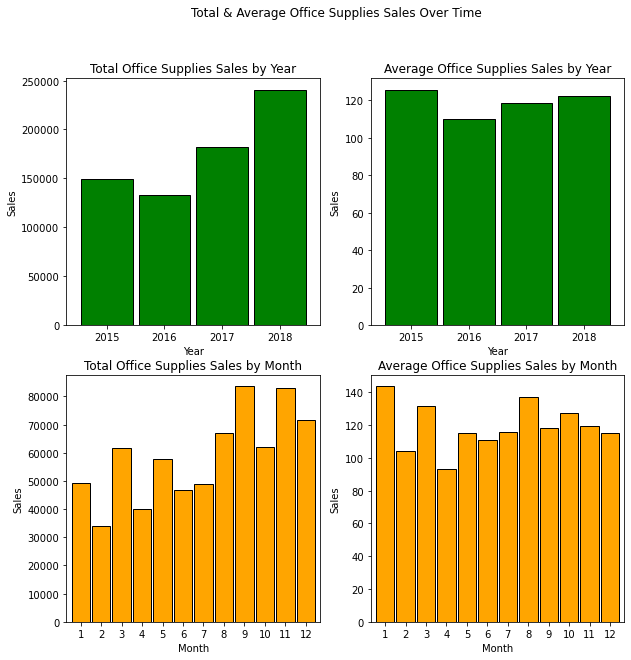

In [60]:
plt.figure(figsize = (10, 10))
plt.suptitle('Total & Average Office Supplies Sales Over Time')

plt.subplot(221)
ax = office_supplies_by_year.total_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Total Office Supplies Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(222)
ax = office_supplies_by_year.average_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Average Office Supplies Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(223)
ax = office_supplies_by_month.total_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Total Office Supplies Sales by Month', xlabel = 'Month', ylabel = 'Sales')

plt.subplot(224)
ax = office_supplies_by_month.average_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Average Office Supplies Sales by Month', xlabel = 'Month', ylabel = 'Sales');

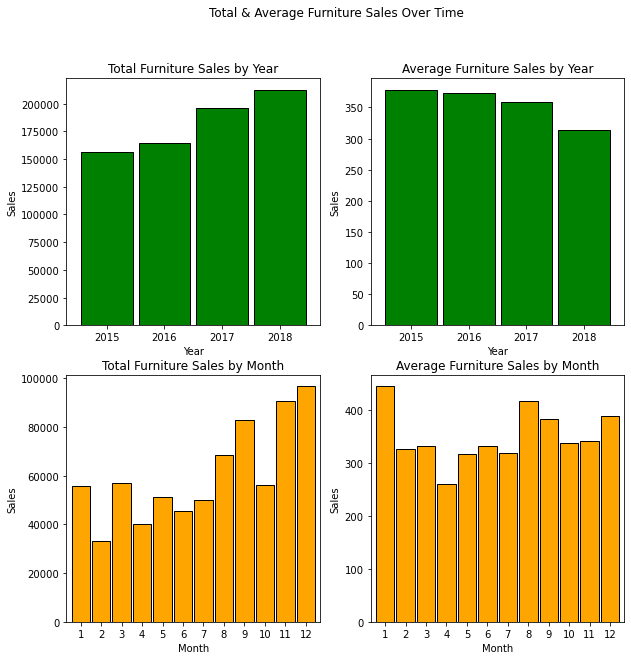

In [61]:
plt.figure(figsize = (10, 10))
plt.suptitle('Total & Average Furniture Sales Over Time')

plt.subplot(221)
ax = furniture_by_year.total_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Total Furniture Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(222)
ax = furniture_by_year.average_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Average Furniture Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(223)
ax = furniture_by_month.total_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Total Furniture Sales by Month', xlabel = 'Month', ylabel = 'Sales')

plt.subplot(224)
ax = furniture_by_month.average_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Average Furniture Sales by Month', xlabel = 'Month', ylabel = 'Sales');

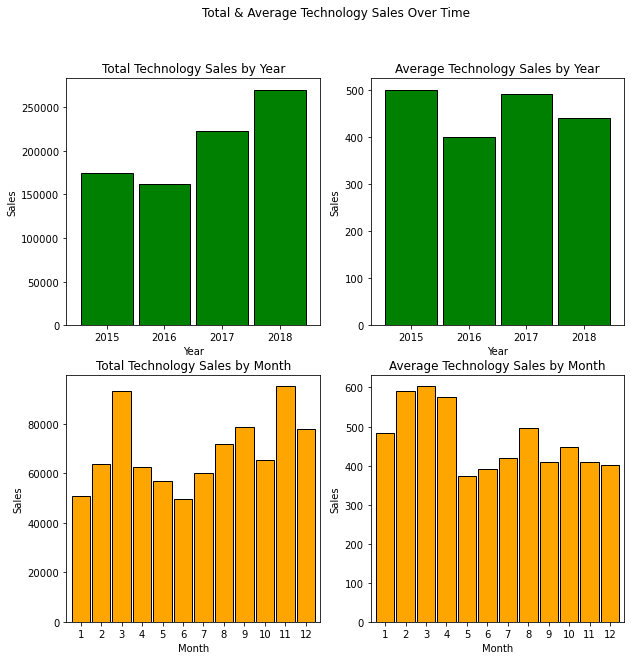

In [62]:
plt.figure(figsize = (10, 10))
plt.suptitle('Total & Average Technology Sales Over Time')

plt.subplot(221)
ax = technology_by_year.total_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Total Technology Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(222)
ax = technology_by_year.average_sales.plot.bar(width=.9, ec='black', color = 'g')
plt.xticks(rotation = 0)
ax.set(title = 'Average Technology Sales by Year', xlabel = 'Year', ylabel = 'Sales')

plt.subplot(223)
ax = technology_by_month.total_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Total Technology Sales by Month', xlabel = 'Month', ylabel = 'Sales')

plt.subplot(224)
ax = technology_by_month.average_sales.plot.bar(width=.9, ec='black', color = 'orange')
plt.xticks(rotation = 0)
ax.set(title = 'Average Technology Sales by Month', xlabel = 'Month', ylabel = 'Sales');

#### Takeaways:
 - Sales overall have steadily increased over time. 
 - As we can see in the sales trend over time visual, a positive trend from 2015 with around 5K in sales to about 55K at YE 2018.
 - Total sales by year: 15: 480K, 16: 459K, 17: 600K, 18: 722K
     - Sales dipped in 16 but it looks like it caught up in 17 and there was an increase in 18.
 - While sales are increasing overall, average sale per customer hasn't increased or remained static but rather it has slightly decreased by year.
     - this might be due to an increase in client base diluting overall sales per customer.
 - Total sales by month seem to pick up around the close of each quarter
 - Average sales by month are higher at the beginning of the year.
 - When looking at sales by category:
     - Office Supplies: follows overall sales trends however, it looks like office supplies are generally bought toward the end of the year
     - furniture: average sales are in decline, there is an uptick in sales at the end of the year
     - technology: sales by year are going up, average sales have a downward trend

#### 3. What regions/states generate the most sales?

In [63]:
df.state.sort_values(ascending = True).unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [64]:
# let's see the top 5 states by sales
pd.DataFrame(df.groupby('state').sales.sum()).sort_values(by = 'sales', ascending = False).head()

,sales
state,
California,446306.4635
New York,306361.1470
Texas,168572.5322
Washington,135206.8500
Pennsylvania,116276.6500


In [65]:
# now let's visualize by the least sales
pd.DataFrame(df.groupby('state').sales.sum()).sort_values(by = 'sales', ascending = False).tail()

,sales
state,
Wyoming,1603.136
South Dakota,1315.560
Maine,1270.530
West Virginia,1209.824
North Dakota,919.910


In [70]:
# for purposes of putting together a map of use, we will use plotly.
# plotly requires the abbreviation of US states in order to map them.

usa_map = df.copy()

state_dict = {'Alabama': 'AL',
        'Alaska': 'AK',
        'Arizona': 'AZ',
        'Arkansas': 'AR',
        'California': 'CA',
        'Colorado': 'CO',
        'Connecticut': 'CT',
        'Delaware': 'DE',
        'District of Columbia': 'DC',
        'Florida': 'FL',
        'Georgia': 'GA',
        'Hawaii': 'HI',
        'Idaho': 'ID',
        'Illinois': 'IL',
        'Indiana': 'IN',
        'Iowa': 'IA',
        'Kansas': 'KS',
        'Kentucky': 'KY',
        'Louisiana': 'LA',
        'Maine': 'ME',
        'Maryland': 'MD',
        'Massachusetts': 'MA',
        'Michigan': 'MI',
        'Minnesota': 'MN',
        'Mississippi': 'MS',
        'Missouri': 'MO',
        'Montana': 'MT',
        'Nebraska': 'NE',
        'Nevada': 'NV',
        'New Hampshire': 'NH',
        'New Jersey': 'NJ',
        'New Mexico': 'NM',
        'New York': 'NY',
        'North Carolina': 'NC',
        'North Dakota': 'ND',
        'Ohio': 'OH',
        'Oklahoma': 'OK',
        'Oregon': 'OR',
        'Pennsylvania': 'PA',
        'Rhode Island': 'RI',
        'South Carolina': 'SC',
        'South Dakota': 'SD',
        'Tennessee': 'TN',
        'Texas': 'TX',
        'Utah': 'UT',
        'Vermont': 'VT',
        'Virginia': 'VA',
        'Washington': 'WA',
        'West Virginia': 'WV',
        'Wisconsin': 'WI',
        'Wyoming': 'WY'}

# adding column with abbreviations by mapping the abbreviation to the state name
usa_map['state_abb'] = usa_map['state'].map(state_dict)

# groupby sales so that when map of US plots, sales are totaled by state
plot_usa_map = usa_map.groupby('state_abb').sales.sum()

In [71]:
fig = px.choropleth(plot_usa_map,
                    locations = plot_usa_map.index,
                    color = 'sales',
                    hover_name = None,
                    locationmode = 'USA-states',
                    color_continuous_scale = 'Sunset',
                    scope = 'usa', 
                    title = 'Total Sales by State')
fig.show()

In [72]:
# let's see what states belong to each region:
for e in list(usa_map['region'].unique()):
    print(e)
    print(usa_map[usa_map['region'] == e].state_abb.sort_values(ascending = True).unique())

Central
['IA' 'IL' 'IN' 'KS' 'MI' 'MN' 'MO' 'ND' 'NE' 'OK' 'SD' 'TX' 'WI']
East
['CT' 'DC' 'DE' 'MA' 'MD' 'ME' 'NH' 'NJ' 'NY' 'OH' 'PA' 'RI' 'VT' 'WV']
West
['AZ' 'CA' 'CO' 'ID' 'MT' 'NM' 'NV' 'OR' 'UT' 'WA' 'WY']
South
['AL' 'AR' 'FL' 'GA' 'KY' 'LA' 'MS' 'NC' 'SC' 'TN' 'VA']


In [73]:
sales_by_region = pd.DataFrame(df.groupby('region').sales.sum())

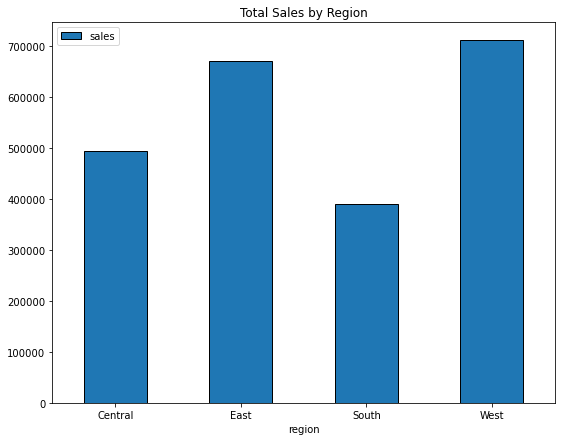

In [74]:
sales_by_region.plot.bar(ec = 'black', figsize = (9, 7))
plt.title('Total Sales by Region')
plt.xticks(rotation = 0)
plt.show();

In [75]:
sales_by_region

,sales
region,
Central,492646.9132
East,669518.7260
South,389151.4590
West,710219.6845


#### Takeaways:
 - Sales are generated only in continental US, with the exception of Alaska.
     - Hawaii and Alaska do not generate sales for the company
     - District of Columbia does generate sales for the company
 - States with highest sales are:
     - CA, NY, TX, WA, and PA
 - States with lowest sales are:
     - WY, SD, ME, WV, ND
 - Regions east and west make up the majority of sales:
     - central: 492K
     - east: 670K
     - south: 389K
     - west: 710K

#### 4. What is the proportion of each clientele segments and what do they buy the most?

In [78]:
segment_sales = pd.DataFrame(df.groupby('segment').sales.sum()).round(2)

''

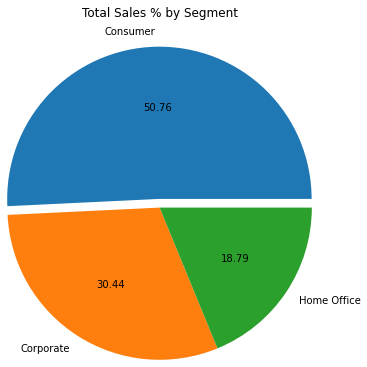

In [79]:
plt.pie(segment_sales.sales, 
        autopct = '%.2f', 
        labels = list(segment_sales.index), 
        explode = (.1, 0, 0),
        radius = 1.75)
plt.title('Total Sales % by Segment', y = 1.35)
;

In [80]:
segment_sales

,sales
segment,
Consumer,1148060.53
Corporate,688494.07
Home Office,424982.18


In [83]:
consumer = df[df['segment'] == 'Consumer']
corporate = df[df['segment'] == 'Corporate']
home_office = df[df['segment'] == 'Home Office']

In [84]:
pd.DataFrame(consumer.groupby(['subcategory','product_name']).sales.sum()).sort_values(by = 'sales', ascending = False).head(10)

sales
subcategory product_name                                                 
Copiers     Canon imageCLASS 2200 Advanced Copier               32899.906
Machines    HP Designjet T520 Inkjet Large Format Printer -...  18374.895
Chairs      HON 5400 Series Task Chairs for Big and Tall        17384.304
Binders     GBC Ibimaster 500 Manual ProClick Binding System    17122.050
            Fellowes PB500 Electric Punch Plastic Comb Bind...  14489.286
            GBC DocuBind TL300 Electric Binding System          13096.054
Supplies    High Speed Automatic Electric Letter Opener         12117.722
Binders     GBC DocuBind P400 Electric Binding System           11976.712
Bookcases   DMI Eclipse Executive Suite Bookcases               11046.609
Phones      Samsung Galaxy Mega 6.3                             10247.756

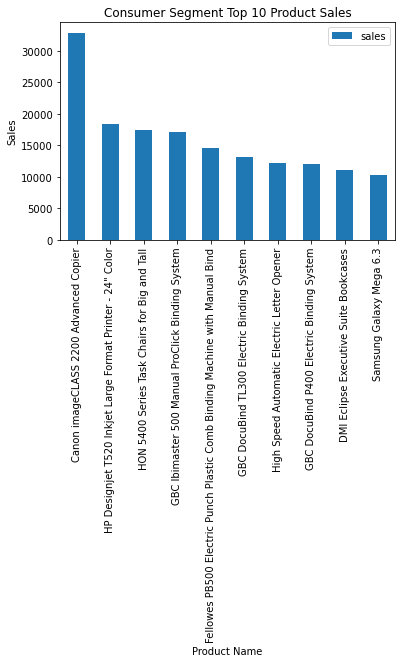

In [85]:
pd.DataFrame(consumer.groupby('product_name').sales.sum()).sort_values(by = 'sales', ascending = False).head(10).plot.bar()
plt.title('Consumer Segment Top 10 Product Sales')
plt.xlabel('Product Name')
plt.ylabel('Sales');

In [86]:
pd.DataFrame(corporate.groupby(['subcategory','product_name']).sales.sum()).sort_values(by = 'sales', ascending = False).head(10)

sales
subcategory product_name                                                 
Copiers     Canon imageCLASS 2200 Advanced Copier               17499.950
Machines    3D Systems Cube Printer, 2nd Generation, Magenta    14299.890
Supplies    Martin Yale Chadless Opener Electric Letter Opener   8328.100
Machines    Cubify CubeX 3D Printer Triple Head Print            7999.980
Binders     Fellowes PB300 Plastic Comb Binding Machine          7759.800
            Fellowes PB500 Electric Punch Plastic Comb Bind...   7117.544
            GBC DocuBind TL300 Electric Binding System           6727.425
Tables      Balt Solid Wood Round Tables                         6518.754
Machines    Lexmark MX611dhe Monochrome Laser Printer            6119.964
Storage     Tennsco Single-Tier Lockers                          5479.964

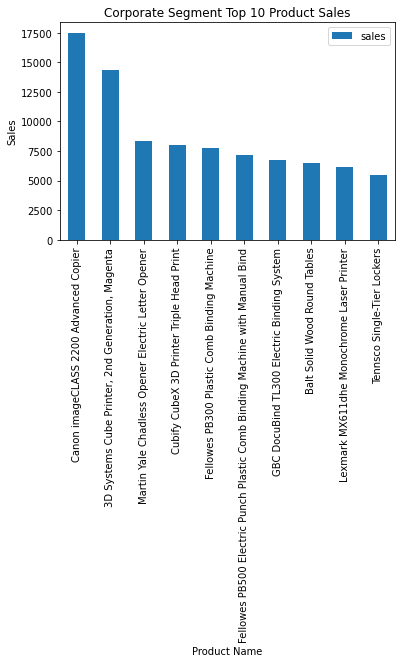

In [87]:
pd.DataFrame(corporate.groupby('product_name').sales.sum()).sort_values(by = 'sales', ascending = False).head(10).plot.bar()
plt.title('Corporate Segment Top 10 Product Sales')
plt.xlabel('Product Name')
plt.ylabel('Sales');

In [88]:
pd.DataFrame(home_office.groupby(['subcategory','product_name']).sales.sum()).sort_values(by = 'sales', ascending = False).head(10)

sales
subcategory product_name                                                 
Machines    Cisco TelePresence System EX90 Videoconferencin...  22638.480
Copiers     Canon imageCLASS 2200 Advanced Copier               11199.968
            Hewlett Packard LaserJet 3310 Copier                 9239.846
Chairs      Global Deluxe High-Back Manager's Chair              7006.510
Binders     GBC DocuBind P400 Electric Binding System            5988.356
            Fellowes PB500 Electric Punch Plastic Comb Bind...   5846.554
Phones      Apple iPhone 5                                       5328.606
Chairs      GuestStacker Chair with Chrome Finish Legs           5055.936
Binders     Ibico EPK-21 Electric Binding System                 4535.976
Chairs      Global Troy Executive Leather Low-Back Tilter        4308.428

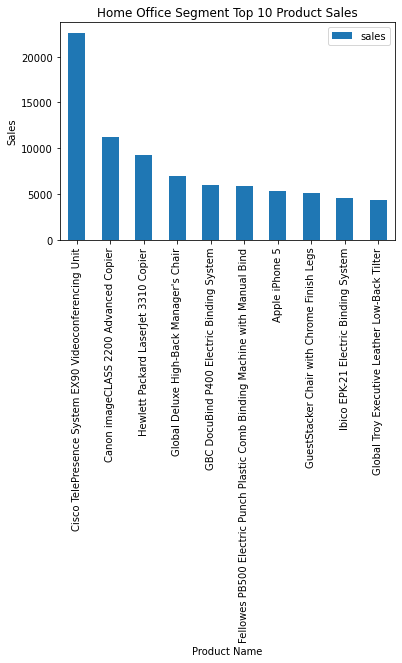

In [89]:
pd.DataFrame(home_office.groupby('product_name').sales.sum()).sort_values(by = 'sales', ascending = False).head(10).plot.bar()
plt.title('Home Office Segment Top 10 Product Sales')
plt.xlabel('Product Name')
plt.ylabel('Sales');

#### Takeaways:
 - There are three segments:
     - consumer: biggest segment at 1,148K sales or 50.76% of their clientele
     - corporate: second biggest segment at 688K or 30.44% of their clientele
     - home office: third biggest segment at 425K or 18.79% of their clientele
 - Copiers, printers and phones are the products that generate the most sales accross all three segments
     - copiers, machines, and supplies subcategories have the products sold the most across all segments.

### Modeling / Forecasting

In [249]:
df

,order_id,ship_date,ship_mode,customer_id,customer_name,segment,city,state,postal_code,region,product_id,category,subcategory,product_name,sales
order_date,,,,,,,,,,,,,,,
2015-01-02,CA-2015-140795,2015-03-02,First Class,BD-11500,Bradley Drucker,Consumer,Green Bay,Wisconsin,54302.0,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900
2015-01-03,CA-2015-168312,2015-07-03,Standard Class,GW-14605,Giulietta Weimer,Consumer,Houston,Texas,77036.0,Central,OFF-ST-10003692,Office Supplies,Storage,Recycled Steel Personal File for Hanging File ...,137.352
2015-01-03,CA-2015-131009,2015-05-03,Standard Class,SC-20380,Shahid Collister,Consumer,El Paso,Texas,79907.0,Central,OFF-FA-10004395,Office Supplies,Fasteners,Plymouth Boxed Rubber Bands by Plymouth,18.840
2015-01-03,US-2015-143707,2015-05-03,Standard Class,HR-14770,Hallie Redmond,Home Office,New York City,New York,10035.0,East,TEC-PH-10003655,Technology,Phones,Sannysis Cute Owl Design Soft Skin Case Cover ...,5.940
2015-01-03,CA-2015-168312,2015-07-03,Standard Class,GW-14605,Giulietta Weimer,Consumer,Houston,Texas,77036.0,Central,FUR-TA-10001866,Furniture,Tables,Bevis Round Conference Room Tables and Bases,376.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-30,CA-2018-115427,2019-03-01,Standard Class,EB-13975,Erica Bern,Corporate,Fairfield,California,94533.0,West,OFF-BI-10004632,Office Supplies,Binders,GBC Binding covers,20.720
2018-12-30,CA-2018-143259,2019-03-01,Standard Class,PO-18865,Patrick O'Donnell,Consumer,New York City,New York,10009.0,East,FUR-BO-10003441,Furniture,Bookcases,"Bush Westfield Collection Bookcases, Fully Ass...",323.136
2018-12-30,CA-2018-143259,2019-03-01,Standard Class,PO-18865,Patrick O'Donnell,Consumer,New York City,New York,10009.0,East,TEC-PH-10004774,Technology,Phones,Gear Head AU3700S Headset,90.930


In [436]:
# let's change the frequency to daily
by_day = pd.DataFrame((df.groupby(df.index).sales.sum().asfreq('D')))

In [439]:
by_day = by_day.fillna(0)

In [248]:
# let's set the index to order_date
df.sort_values(by = 'order_date', inplace = True)
df.set_index('order_date', inplace = True)

In [441]:
# identify proportions for split:

#train_size = int(len(df) * .5)
#validate_size = int(len(df) * .3)
#test_size = int(len(df) - train_size - validate_size)
#validate_end_index = train_size + validate_size

# let's split the dataset:
by_day = df[: '2017-05-31 00:00:00']
by_day = df['2017-06-02 00:00:00' : '2018-06-15 00:00:00']
by_day = df['2018-06-16 00:00:00' : '2018-12-30 00:00:00']

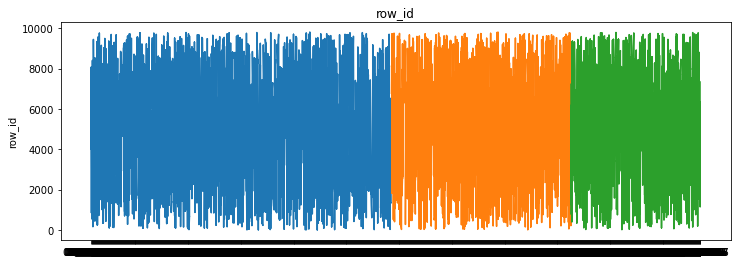

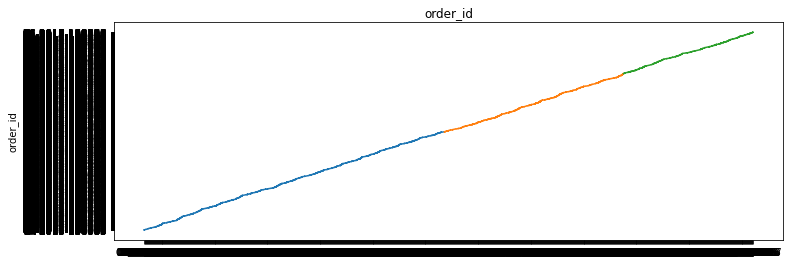

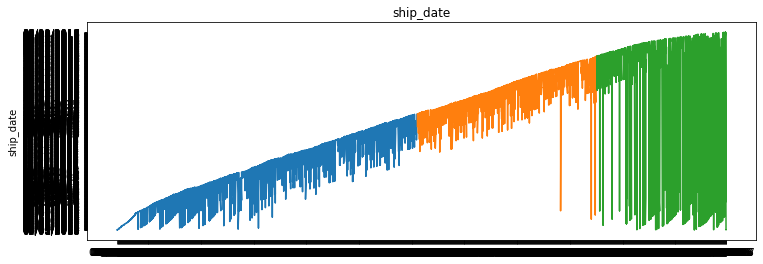

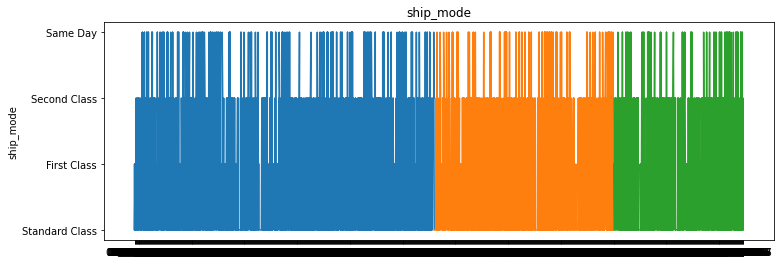

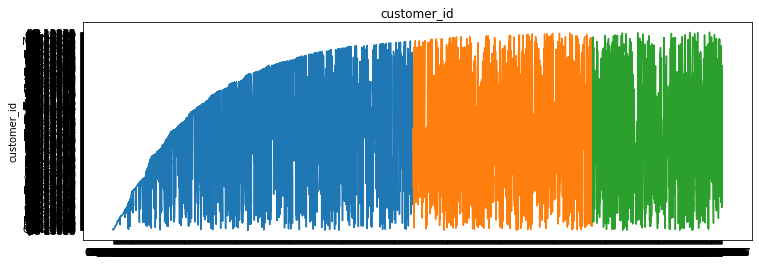

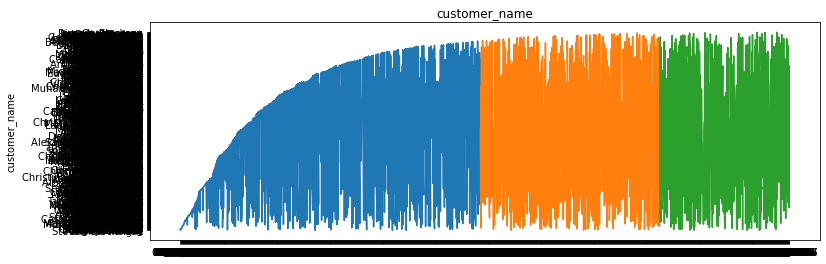

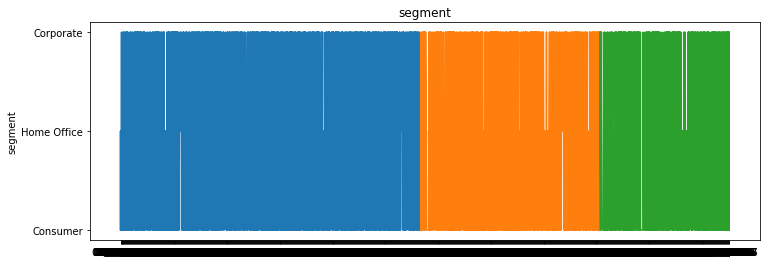

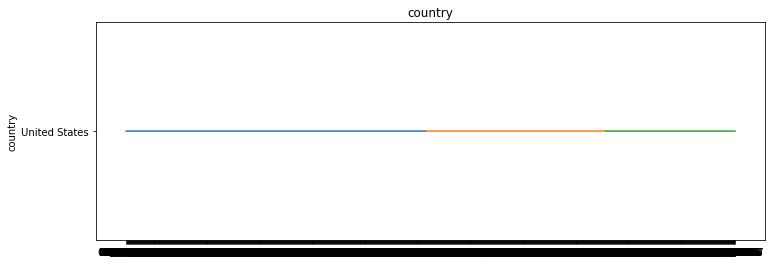

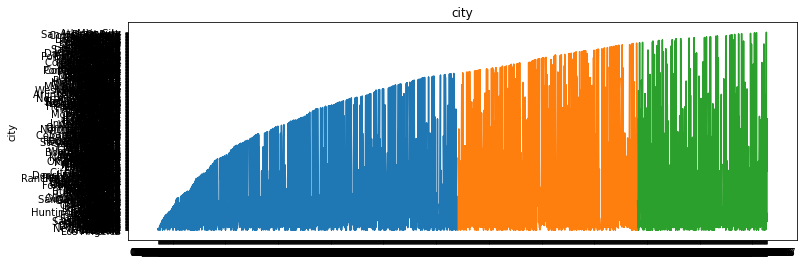

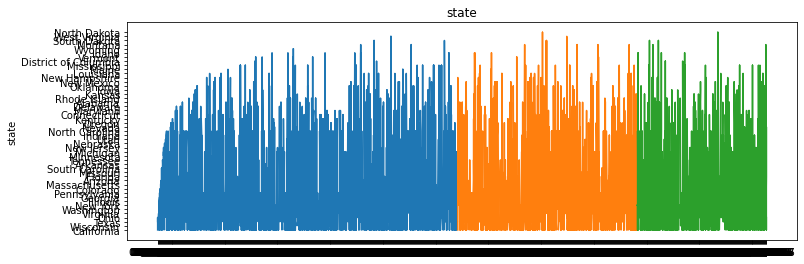

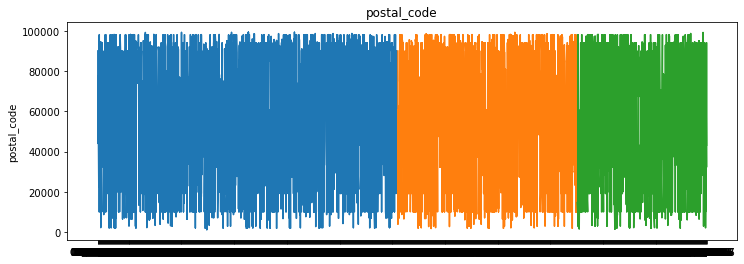

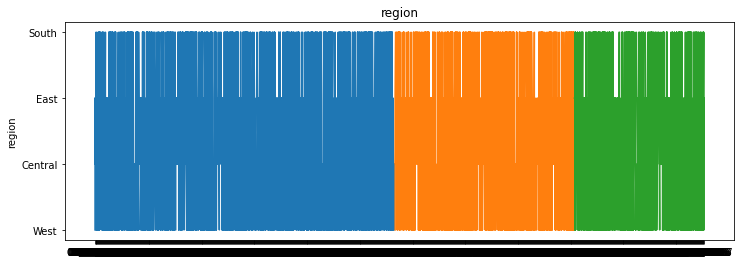

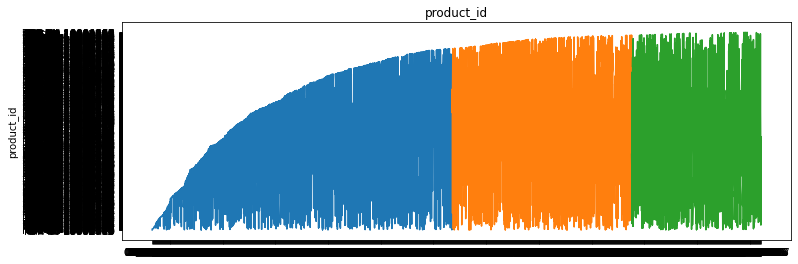

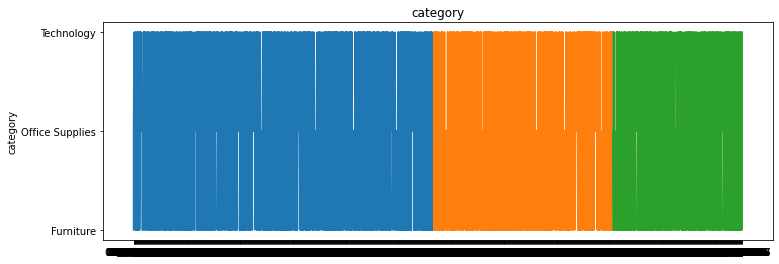

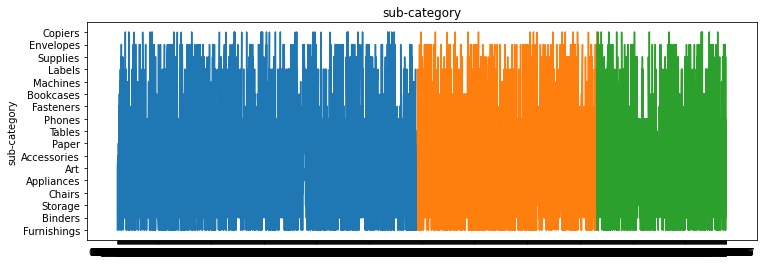

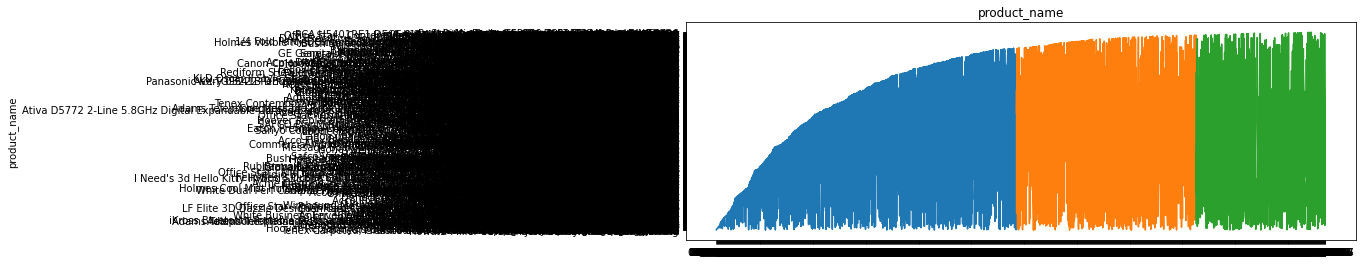

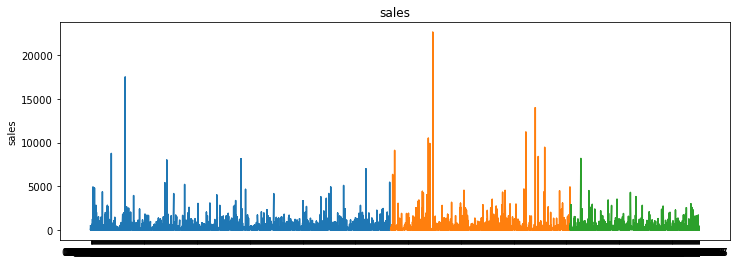

In [166]:
# verify that split looks correct
for col in train.columns:
    plt.figure(figsize = (12,4))
    plt.plot(train[col], label = 'train')
    plt.plot(validate[col], label = 'validate')
    plt.plot(test[col], label = 'test')
    plt.ylabel(col)
    plt.title(col)
    plt.show();

In [442]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.title('Sales Over Time')
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


#### Last Observed Value

In [443]:
sales = train['sales'][-1:][0]
yhat_df = pd.DataFrame({'sales': [sales]}, index = validate.index)
yhat_df.head().T

order_date,2017-01-02,2017-01-02,2017-01-03,2017-01-03,2017-01-03
sales,116.4,116.4,116.4,116.4,116.4


sales -- RMSE: 683


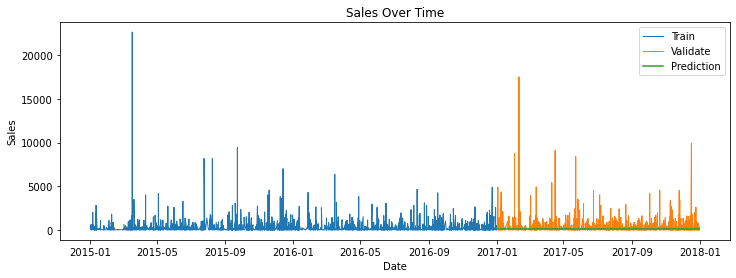

In [444]:
plot_and_eval('sales')

In [445]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                        target_var = 'sales')
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,683.0


#### Simple Average

In [446]:
sales = round(train['sales'].mean(), 2)
yhat_df = pd.DataFrame({'sales': [sales]}, index = validate.index)
yhat_df.head().T

order_date,2017-01-02,2017-01-02,2017-01-03,2017-01-03,2017-01-03
sales,234.35,234.35,234.35,234.35,234.35


sales -- RMSE: 673


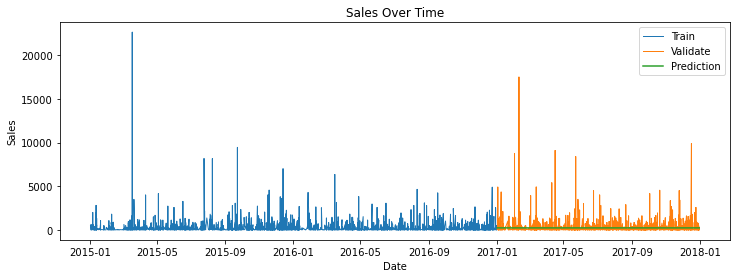

In [447]:
plot_and_eval('sales')

In [448]:
eval_df = append_eval_df(model_type = 'simple_average', 
                        target_var = 'sales')
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,683.0
1,simple_average,sales,673.0


#### Moving Average

In [449]:
period = 30

sales = round(train['sales'].rolling(period).mean().iloc[-1], 2)

yhat_df = pd.DataFrame({'sales': [sales]}, index = validate.index)

yhat_df.head().T

order_date,2017-01-02,2017-01-02,2017-01-03,2017-01-03,2017-01-03
sales,243.87,243.87,243.87,243.87,243.87


sales -- RMSE: 673


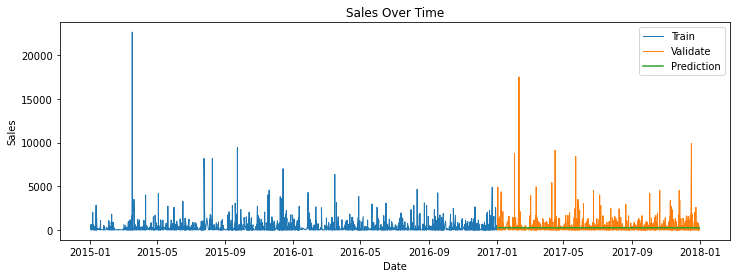

In [450]:
plot_and_eval('sales')

In [451]:
eval_df = append_eval_df(model_type = '30d_moving_average', 
                        target_var = 'sales')
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,683.0
1,simple_average,sales,673.0
2,30d_moving_average,sales,673.0


In [452]:
periods = [1, 4, 12, 26, 52, 104]

for p in periods:
    sales = round(train['sales'].rolling(p).mean().iloc[-1], 2)
    
    yhat_df = pd.DataFrame({'sales': [sales]}, index = validate.index)

    model_type = str(p) + 'd_moving_average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'sales'
                            )
eval_df

,model_type,target_var,rmse
0,last_observed_value,sales,683.0
1,simple_average,sales,673.0
2,30d_moving_average,sales,673.0
3,1d_moving_average,sales,683.0
4,4d_moving_average,sales,679.0
5,12d_moving_average,sales,680.0
6,26d_moving_average,sales,673.0
7,52d_moving_average,sales,673.0
8,104d_moving_average,sales,673.0


#### Conclusion & Takeaways

#### Next Steps